In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install segmentation_models
!pip install albumentations==0.4.5

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from PIL import Image
import albumentations as A
import glob

import skimage.transform as sk_transform
import skimage.filters as sk_filters

from skimage.measure import label, regionprops
import os

import numpy as np

from sklearn import model_selection

In [ ]:
def get_aug(aug, min_area=0., min_visibility=0.):
    bbox_params = A.BboxParams(format='coco', min_area=min_area, min_visibility=min_visibility, label_fields=['category_id'])
    return A.Compose(aug, bbox_params)


class DataLoader(tf.keras.utils.Sequence):
    '''
    DataLoader is responsible for creating of batches.
    '''
    def __init__(self, 
                 dataset, 
                 batch_size, 
                 shuffle=True, 
                 output_size=(512,512), 
                 is_validation=False,
                 **kwargs):
        self.dataset = dataset
        self._len = len(self.dataset)
        self.indices = range(self._len)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self._output_size = output_size
        self.aug = self.init_aug(is_validation)        
        self.on_epoch_end()

    def init_aug(self, is_validation):
        if is_validation:
          aug = get_aug([                      
              A.Resize(width=self._output_size[0], height=self._output_size[1], always_apply=True),
              A.Normalize(),
            ], min_visibility=0.1)
        else:
          aug = get_aug([
              A.RGBShift(p=0.1),            
              # A.JpegCompression(p=0.2, quality_lower=80),
              A.OneOf([
                  A.RandomBrightnessContrast(p=0.5),            
                  A.HueSaturationValue(),
                  A.RandomGamma(p=0.25),
                  A.RandomBrightness(p=0.25),
                  A.Blur(blur_limit=2,p=0.25),
              ],p=0.3),
              
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.05),
                          
              A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.05, rotate_limit=15,  border_mode=0, p=0.3, value=(144.75479165, 137.70713403, 129.666091), mask_value=0.0 ),
              
              
                  #A.RandomSizedBBoxSafeCrop(width=self._output_size[0], height=self._output_size[1], erosion_rate=0.2, always_apply=True),
              A.Resize(width=self._output_size[0], height=self._output_size[1], always_apply=True),
              
              
              
              A.Normalize(),
          ], min_visibility=0.1)
        return aug
        
    def __len__(self):        
        return self._len // self.batch_size

    def __getitem__(self, index):
        """ Generate one batch of data. """
        s = index * self.batch_size % self._len
        e = s + self.batch_size
        indices = self.indices[s:e]

        return self.__data_generator(indices)

    def on_epoch_end(self):
        """ Updates indices after each epoch. """
        if self.shuffle:
            self.indices = np.random.permutation(self._len)
            
    def augment(self, img, mask):
        label_image = label(mask)
        bboxes = []
        for region in regionprops(label_image):
            if region.area >= 100:
                minr, minc, maxr, maxc = region.bbox
                bboxes.append((minc, minr, maxc-minc, maxr-minr )) 
                
        if len(bboxes) == 0:
            bboxes = [ [0, 0, img.shape[1], img.shape[0]] ]
            
        new_img = None
        new_mask = None
        try:
            annotations = {'image': img, 
                   "masks" : [mask],
                   'bboxes': bboxes,
                   'category_id' : [255] * len(bboxes)}
            
            augmented = self.aug(**annotations)
            new_img = augmented['image']
            new_mask = augmented["masks"][0]
        except Exception as e:
            print(e)
            new_img = img
            new_mask = mask
        return new_img, new_mask
        

    def __data_generator(self, indices):
        # Init the matrix
        batch_images, batch_target = [], []
        for idx in indices:
            image_path, label_path = self.dataset[idx]
            image = np.array(Image.open(image_path).convert('RGB'))
            target = np.array(Image.open(label_path))

            ## Rescale masks from [0; 255] to [0; 1]
            target[target > 0] = 1
            target = target.astype('float32')                                        
            
            image, target = self.augment(image, target)            
            # if shape of mask is not h*w*c
            if len(target.shape) != 3:
                ## the keras model require h*w*1
                target = np.expand_dims(target, axis=-1)
            
            batch_images.append(image)
            batch_target.append(target)
        
        if len(batch_images) < self.batch_size:
            pad_images = [np.zeros_like(batch_images[0]) 
                          for _ in range(self.batch_size-len(batch_images))]
            pad_target = [np.zeros_like(batch_target[0]) 
                          for _ in range(self.batch_size-len(batch_target))]
            batch_images.extend(pad_images)
            batch_target.extend(pad_target)

        return np.stack(batch_images), np.stack(batch_target)

In [ ]:
base_dir = "/content/drive/My Drive/datasets/processed"
ims_dir = os.path.join(base_dir, "imgs")
labels_dir = os.path.join(base_dir, "labels")
img_files = sorted(glob.glob(ims_dir + "/*.*"))
mask_files = sorted(glob.glob(labels_dir + "/*.png"))

In [ ]:
len(img_files) ,len (mask_files)

(5709, 5709)

In [ ]:
dataset = list(zip(img_files, mask_files))

In [ ]:
train_dataset, test_dataset = model_selection.train_test_split(dataset, test_size=0.2, random_state=0)

In [ ]:
len(train_dataset), len(test_dataset)

(4567, 1142)

In [ ]:
train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, output_size=(256, 256), shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=16, output_size=(256, 256), is_validation=True, shuffle=False)

In [ ]:
batch = test_data_loader[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

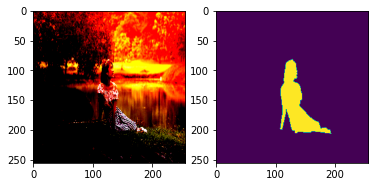

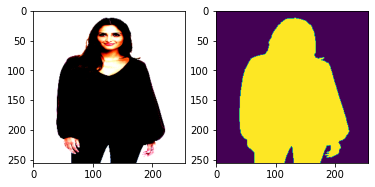

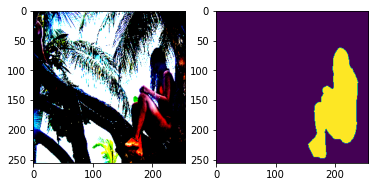

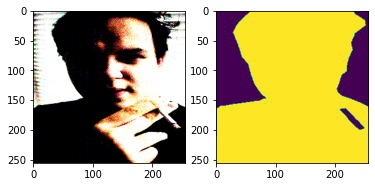

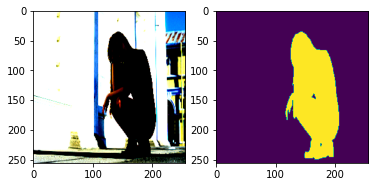

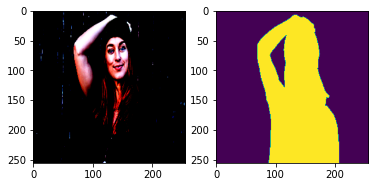

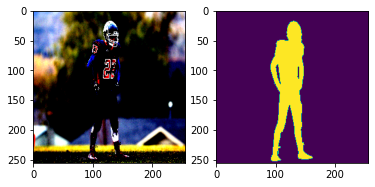

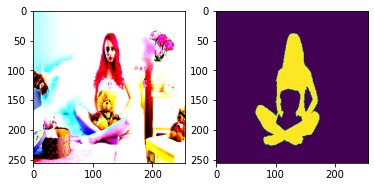

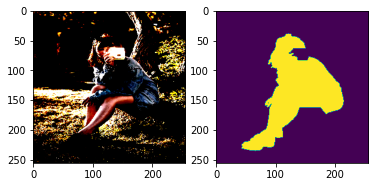

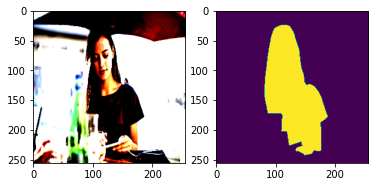

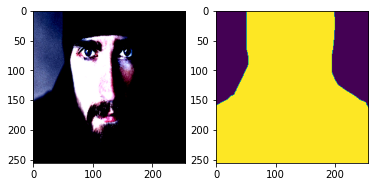

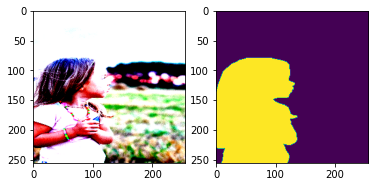

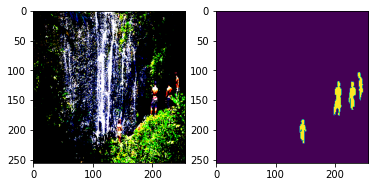

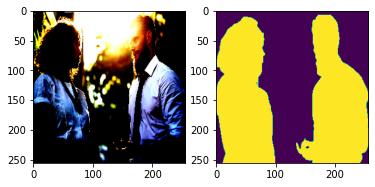

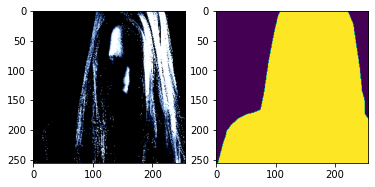

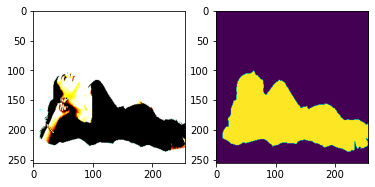

In [ ]:
for i in range(16):
  fig, axes = plt.subplots(1, 2,)
  axes[0].imshow(batch[0][i])
  axes[1].imshow(batch[1][i].squeeze())
# plt.imshow()

In [ ]:
OUTPUT_CHANNELS = 1

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False, weights="imagenet")

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
# down_stack.trainable = True

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  x = tf.keras.layers.Activation('sigmoid')(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)

In [ ]:
LR = 0.0001
EPOCHS = 40

In [ ]:
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)
total_loss = focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

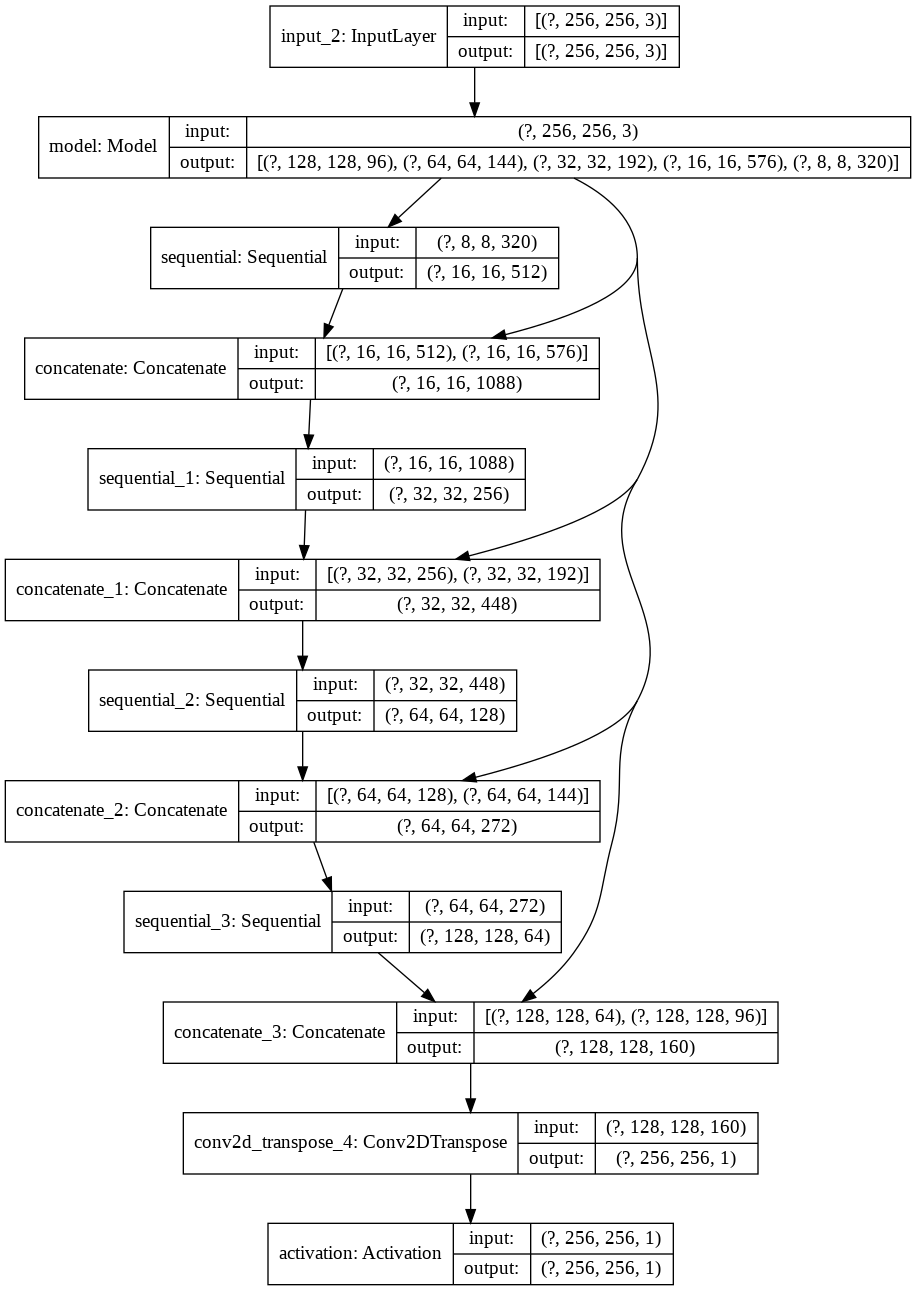

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model_checkpoint_path = '/content/drive/My Drive/nn/segmentation_research/best_dice_loss.h5'
log_dir_path = "/content/drive/My Drive/nn/segmentation_research/logs_dice_loss"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path, save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir_path)
]

In [ ]:
history = model.fit(
    train_data_loader, 
    steps_per_epoch=len(train_data_loader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=test_data_loader, 
    validation_steps=len(test_data_loader),
    use_multiprocessing=False,
    workers=1
) 

Epoch 1/40
285/285 [==============================] - 1736s 6s/step - loss: 0.0675 - iou_score: 0.4574 - f1-score: 0.6173 - val_loss: 0.0287 - val_iou_score: 0.5159 - val_f1-score: 0.6791 - lr: 1.0000e-04
Epoch 2/40
285/285 [==============================] - 1057s 4s/step - loss: 0.0258 - iou_score: 0.6207 - f1-score: 0.7646 - val_loss: 0.0213 - val_iou_score: 0.6445 - val_f1-score: 0.7825 - lr: 1.0000e-04
Epoch 3/40
285/285 [==============================] - 1059s 4s/step - loss: 0.0223 - iou_score: 0.6614 - f1-score: 0.7949 - val_loss: 0.0190 - val_iou_score: 0.6890 - val_f1-score: 0.8144 - lr: 1.0000e-04
Epoch 4/40
285/285 [==============================] - 1044s 4s/step - loss: 0.0201 - iou_score: 0.6911 - f1-score: 0.8161 - val_loss: 0.0183 - val_iou_score: 0.6797 - val_f1-score: 0.8077 - lr: 1.0000e-04
Epoch 5/40
285/285 [==============================] - 1048s 4s/step - loss: 0.0190 - iou_score: 0.7029 - f1-score: 0.8243 - val_loss: 0.0172 - val_iou_score: 0.6778 - val_f1-score: